In [ ]:
#Import modules

import pandas as pd
import requests
import numpy as np
import json
from utils import MonteCarloFunctions as mcf
from utils import AlpacaFunctions as apf
import datetime as dt
import hvplot.pandas
import matplotlib.pyplot as plt


**Below we are going to define functions we will be using repeatedly within the project -- will probably need to be moved to a separate .py file in order to "modularize" our app.  We will then be able to import the relevant functions from the separate file.

In [ ]:
#Establish ARK API variables -- base url for api calls, request type i.e. profile, trades, etc., etf_symbol for desired etf and additional arguments as parameters
 
holdings_symbol = 'ARKK'
holdings_url = 'https://arkfunds.io/api/v2/etf/holdings'  

#Initial API call to establish current positions for ARKK
# need to code for an error response if API call is unsuccessfsul i.e. if response.status_code == 200:
response = requests.get(holdings_url, params = {'symbol' : 'ARKK'}).json()
#print(json.dumps(response, indent=4, sort_keys=True))

**Something for us to consider -- would it be better to utilize dataframes or databases to manipulate and analyze our data?

In [84]:
# We want to create a dataframe with the relevant 'holdings' data from the json object returned above
initial_holdings_df = pd.DataFrame(response['holdings']).dropna(axis=0)
#display(holdings_df)

#Check to confirm we have dropped null values in our DataFrame
display(initial_holdings_df.isnull().sum())


fund            0
date            0
ticker          0
company         0
cusip           0
shares          0
market_value    0
share_price     0
weight          0
weight_rank     0
dtype: int64

**To be done for project -- we need to find a solution for null values in our holdings dataframe as it could change and we do not necessarily want to have to dig in and figure out which value is null and what belongs there... possibly create an if/then statement for null values and how to handle them i.e. alert the user of the null value and provide options for  how to handle it.  For the purposes of our MVP, we are going to drop rows with null values since the recurring null value is for a ticker with very little impact on the portfolio.  For future consideration would be a more elegant way to handle null values, but for now we will simply drop them.  NOTE:  this will cause our weights to not equal 100, thus we must rebalance the weights so we can run our calculations.

,ticker,weight,company
0,TSLA,10.39,TESLA INC
1,TDOC,6.65,TELADOC HEALTH INC
2,COIN,6.10,COINBASE GLOBAL INC -CLASS A
3,U,5.79,UNITY SOFTWARE INC
4,ROKU,5.11,ROKU INC


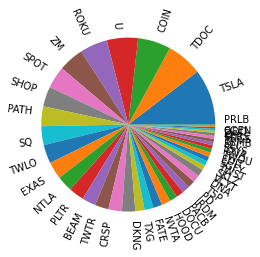

In [86]:
# For our purposes we want to focus on the 'ticker','weight', and 'company' columns of the dataframe.  This will allow us to perform historical research with the Alpaca API as well as plot the weights of the portfolio stocks.
initial_filtered_df = initial_holdings_df[['ticker', 'weight', 'company']]
display(initial_filtered_df.head())

# Note that for our Monte Carlo simulations, we will need to divide the weights column by 100 since the sum of weights for the simulation needs to be 1, and the dataframe is configured for the sum to be 100.

initial_filtered_bar = filtered_df.hvplot.bar(x='ticker', y = 'weight', hover_color = 'red', hover_cols = ['ticker', 'weight', 'company'],rot=90, title = 'Stock tickers and their corresponding weights in the portfolio')
initial_filtered_pie = plt.pie(x = filtered_df.weight, labels = filtered_df.ticker,rotatelabels=True)

In [87]:
#Use data from ARKK API call to get historical quotes from Alpaca
tickers = filtered_df['ticker'].astype(str).tolist()
timeframe = '1D'
today = pd.Timestamp.now(tz="America/New_York")
three_years_ago = pd.Timestamp(today - pd.Timedelta(days=1095)).isoformat()
end_date = today
# Do we want to use 1, 2, 3 years of historical data or more?
start_date = three_years_ago
# Here we are retrieving the historical data for the stocks in the ARKK portfolio.  
# We then filter the results to leave us with closing price and ticker columns with a datetime index 
# so we can run our analyses.

#ARKK broken up into individual stocks:
initial_portfolio_df = apf.get_historical_dataframe(tickers, start_date, end_date, timeframe)

#ARKK fund as a whole:
arkk_df = apf.get_historical_dataframe('ARKK', start_date, end_date, timeframe)

#QQQ for comparison purposes
qqq_df = apf.get_historical_dataframe('QQQ', start_date, end_date, timeframe)

**TBD for project -- how will we handle timeframes for our historical analyses i.e. do we want a hard coded time period or allow for user input?  Also how will this affect stocks that have no data for certain periods as well as those who have a more extensive price history.

**One thing to consider for our daily returns calculations.. it's possible we can just set up the Monte Carlo simulation and then pull the returned daily returns to use in our risk/return analyses -- YES WE CAN!

**Below we create functions for the monte carlo simulations... these will probably need to be separated into a separate module.

In [88]:
# In order to use the weights from the portfolio dataframe in our Monte Carlo simulations, we will need to divide them by 100.
# Initially we use the weights we received from our API call to retrieve ARKK's holdings -- 
# the user will be allowed to change these and we will update them for calcuations
# display(initial_holdings_df.weight)
# Dividing the weights by 100
initial_mc_weights = list(initial_holdings_df.weight / 100)
# display(initial_mc_weights)
num_simulations = 500
num_trading_days = 252*3

# Creating initial MC Simulation DataFrames
# For ARKK ETF stocks (before updating)
portfolio_initial_sim_input = mcf.configure_monte_carlo(initial_portfolio_df, initial_mc_weights, num_simulations, num_trading_days)

# For QQQ ETF (for comparison purposes)
qqq_sim_input = mcf.configure_monte_carlo(qqq_df, [1], num_simulations, num_trading_days)

# For the ARKK ETF
arkk_sim_input = mcf.configure_monte_carlo(arkk_df, [1], num_simulations, num_trading_days)

In [91]:
# We will isolate the daily returns column from our MC_portfolio dataframe in order to run our risk / return analyses by
# merging the 'daily_return' series from our dataframe 
initial_portfolio_daily_returns = pd.DataFrame()
# Iterate through tickers in our MC DataFrame, filter to isolate 'daily_return' data, then concat the resulting series into 
# dataframe we can use for our analyses on the individual stocks in the portfolio
for ticker in tickers:
    daily_returns = portfolio_initial_sim_input.portfolio_data[ticker]['daily_return']
    initial_portfolio_daily_returns = pd.concat([initial_portfolio_daily_returns, daily_returns], axis=1)
initial_portfolio_daily_returns.columns = tickers
#display(initial_portfolio_daily_returns.head())

# Daily returns for 'QQQ' ETF for comparison
qqq_daily_returns = qqq_sim_input.portfolio_data['QQQ']['daily_return']

# Daily Returns for 'ARKK' ETF 
arkk_daily_returns = arkk_sim_input.portfolio_data['ARKK']['daily_return']
#display(qqq_daily_returns)
#display(arkk_daily_returns)

In [94]:
# Calculating standard deviations of the daily returns and plotting the results.
initial_portfolio_std = initial_portfolio_daily_returns.std().sort_values()
qqq_daily_returns_std = pd.Series(qqq_daily_returns.std(), index = ['QQQ'])
arkk_daily_returns_std = pd.Series(arkk_daily_returns.std(), index = ['ARKK'])
combined_std = pd.concat([initial_portfolio_std, arkk_daily_returns_std, qqq_daily_returns_std], join='inner', ignore_index=False)
comparison_std_barplot = combined_std.hvplot.bar(title = 'Initial comparisons of standard deviations of daily return data (higher # = more volatile)', color = 'red', xlabel = 'Ticker', 
                                                ylabel = 'Standard Deviation of Daily Returns', rot = 90)
display(comparison_std_barplot)



:Bars   [index]   (0)

In [104]:
# Calculating the Sharpe Ratios for our initial portfolio stocks, ARKK and QQQ
# First we calculate annual return data for our datasets
year_trading_days = 252
initial_portfolio_annual_return = initial_portfolio_daily_returns.mean() * year_trading_days
arkk_annual_return = arkk_daily_returns.mean() * year_trading_days
qqq_annual_return = qqq_daily_returns.mean() * year_trading_days

# Now we calculate the annualized standard deviation
initial_portfolio_annual_std = initial_portfolio_std * np.sqrt(year_trading_days)
qqq_annual_std = qqq_daily_returns_std * np.sqrt(year_trading_days)
arkk_annual_std = arkk_daily_returns_std * np.sqrt(year_trading_days)

# Lastly, we calculate and plot the Sharpe ratios
# Calculate the ratios
initial_portfolio_sharpe = initial_portfolio_annual_return / initial_portfolio_annual_std
initial_portfolio_sharpe.sort_values(inplace=True)
qqq_sharpe = qqq_annual_return / qqq_annual_std
arkk_sharpe = arkk_annual_return / arkk_annual_std
combined_sharpe = pd.concat([initial_portfolio_sharpe, qqq_sharpe, arkk_sharpe]).sort_values()
# Plot the ratios
initial_sharpe_plot = initial_portfolio_sharpe.hvplot.bar(xlabel = 'Tickers', ylabel = 'Sharpe Ratios', title = 'Sharpe Ratios of initial portfolio stocks vs. QQQ and ARKK', color = 'red', label = 'Initial Portfolio Stocks', rot = 90)
arkk_sharpe_plot = arkk_sharpe.hvplot.bar(xlabel = 'Tickers', ylabel = 'Sharpe Ratios', title = 'Sharpe Ratio of ARKK', label = 'ARKK', color='blue', rot = 90)
qqq_sharpe_plot = qqq_sharpe.hvplot.bar(xlabel = 'Tickers', ylabel = 'Sharpe Ratios', title = 'Sharpe Ratio of QQQ', label = 'QQQ', color='purple', rot=90)
combined_sharpe_plot = initial_sharpe_plot * arkk_sharpe_plot * qqq_sharpe_plot
display(combined_sharpe_plot)
#display(combined_sharpe)

:Overlay
   .Bars.Initial_Portfolio_Stocks :Bars   [index]   (0)
   .Bars.ARKK                     :Bars   [index]   (0)
   .Bars.QQQ                      :Bars   [index]   (0)

**At some point would we like to also plot returns for QQQ or S&P and ARKK and some other fund for reference?

In [111]:
# Calculating and plotting cumulative returns for the stocks in ARKK
initial_portfolio_cumprod = (1 + initial_portfolio_daily_returns).cumprod()
initial_portfolio_cum_plot = initial_portfolio_cumprod.hvplot(kind = 'line', rot=90, title = 'Cumulative returns for the individual stocks in ARKK over time', ylabel = 'Returns', xlabel = 'Date', legend = 'left', fontsize = {'legend' : '5px'})
# For 'ARKK' as  whole
arkk_returns_cumprod = (1 + arkk_daily_returns).cumprod()
arkk_cum_plot = arkk_returns_cumprod.hvplot(kind = 'line', rot=90, title = 'Cumulative returns for ARKK vs QQQ', ylabel = 'Returns', xlabel = 'Date', label = 'ARKK')
# For 'QQQ' as a whole
qqq_returns_cumprod = (1 + qqq_daily_returns).cumprod()
qqq_cum_plot = qqq_returns_cumprod.hvplot(kind = 'line', rot=90, title = 'Cumulative returns for QQQ', ylabel = 'Returns', xlabel = 'Date', label = 'QQQ')
display(initial_portfolio_cum_plot) 
display(arkk_cum_plot * qqq_cum_plot)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

:Overlay
   .Curve.ARKK :Curve   [time]   (daily_return)
   .Curve.QQQ  :Curve   [time]   (daily_return)

**TODO -- we need to run other risk / return analyses on the fund i.e. sharpe ratio, other variance measures to complete the full picture of the analysis

### Calling the Monte Carlo functions and running projections -- 

In [69]:
# Run the simulations:
# Initially ARKK simulation data will consist of the initial holdings of the ETF -- 
# future simulations will be variable depending on how the user wants to manipulate the portfolio)
arkk_intial_sim_returns = mcf.run_monte_carlo(portfolio_initial_sim_input)
qqq_sim_returns = mcf.run_monte_carlo(qqq_sim_input)
arkk_intial_sim_returns.head()
qqq_sim_returns.head()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.006858,1.007608,1.019303,0.998069,0.988153,1.004028,0.994440,0.999904,1.023718,1.000875,...,0.999115,1.023502,0.998463,0.994825,0.985610,0.969549,0.995666,0.985548,1.018980,1.006843
2,0.986766,1.010104,1.025378,1.003073,0.964463,1.004521,0.962136,1.002130,1.041753,1.015985,...,1.004934,1.004684,0.977065,1.011333,0.971581,0.950668,0.996636,0.994905,1.005692,1.010692
3,0.976241,1.001728,1.041872,1.009299,0.944331,1.037132,0.983085,1.005755,1.035807,1.016677,...,1.027085,0.992546,0.993328,1.046798,0.965431,0.930111,0.991271,0.977966,0.990235,1.012955
4,0.993750,1.019670,1.045150,0.985296,0.933659,1.042110,0.951232,1.012797,1.028269,1.026852,...,1.014952,1.004323,0.986041,1.070372,0.932995,0.928837,0.991954,0.980185,1.004065,1.014658


In [78]:
# Plotting the median projected returns via the MCForecast projections
qqq_median_outcomes = qqq_sim_returns.median(axis=1)
arkk_intial_median_outcomes = arkk_sim_returns.median(axis=1)
qqq_median_plot = qqq_median_outcomes.hvplot(ylabel = 'Median returns', xlabel = 'Days of projection', title = f'Median returns from {num_simulations} simulations over {num_trading_days} trading days for QQQ vs ARKK', label = 'QQQ')
arkk_median_initial_plot = arkk_intial_median_outcomes.hvplot(ylabel = 'Median returns', xlabel = 'Days of projection', title = f'Median returns from {num_simulations} simulations over {num_trading_days} trading days for QQQ vs ARKK', label = 'ARKK')
initial_combined_median_plot = qqq_median_plot * arkk_median_initial_plot
initial_combined_median_plot



:Overlay
   .Curve.QQQ  :Curve   [index]   (0)
   .Curve.ARKK :Curve   [index]   (0)

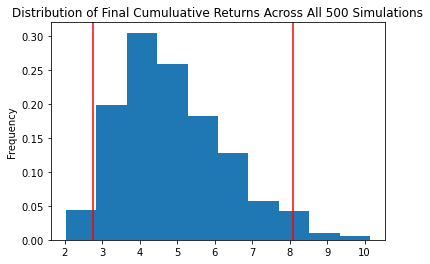

In [80]:
# Plotting distribrution and confidence intervals from Monte Carlo Simulation
# This is the plot for the simulations using the individual stocks within ARKK and can be manipulated...
# this plot will be variable whereas the 'ARKK' and 'QQQ' PLOT
arkk_intial_distribution_plot = mcf.plot_distribution(portfolio_initial_sim_input)

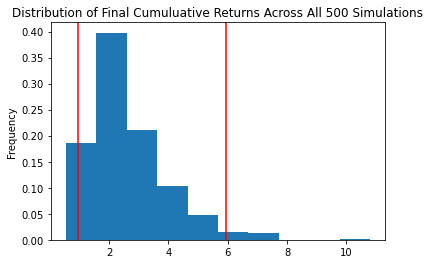

In [81]:
qqq_distribution_plot = mcf.plot_distribution(qqq_sim_input)

In [82]:
# Describe the MCForecast Summary
arkk_initial_simulation_summary = mcf.get_monte_summary(portfolio_initial_sim_input)
qqq_simulation_summary = mcf.get_monte_summary(qqq_sim_input)
display(arkk_initial_simulation_summary)
display(qqq_simulation_summary)

count           500.000000
mean              4.870803
std               1.417167
min               2.027629
25%               3.797372
50%               4.680208
75%               5.737095
max              10.145667
95% CI Lower      2.764567
95% CI Upper      8.084854
Name: 756, dtype: float64

count           500.000000
mean              2.626259
std               1.284319
min               0.540771
25%               1.761420
50%               2.359044
75%               3.235401
max              10.799898
95% CI Lower      0.961550
95% CI Upper      5.939078
Name: 756, dtype: float64

### We should get to this point after running our initial script -- The initial analyses should and plots should remain static while we generate variable plots and analyses based on the users changes.